$❑\, \, $ **Step 0 引入文件并设置图像参数**

In [1]:
%matplotlib inline
# “在 jupyter notebook 在线使用 matplotlib”，为 IPython 的内置 magic 函数，在 Pycharm 中不被支持
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.datasets as datasets

plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = ['STKaiti']
plt.rcParams['axes.unicode_minus'] = False

$❑\, \, $ **Step 1 导入数据并对数据进行处理**

&emsp;&emsp;利用 TensorFlow 自动在线下载 MNIST 数据集，并转换为 Numpy 数组格式。

In [2]:
def load_data() :
    # 加载 MNIST 数据集 元组tuple: (x, y), (x_val, y_val)
    (x, y), (x_val, y_val) = datasets.mnist.load_data()
    # 将 x 转换为浮点张量，并从 0 ~ 255 缩放到 [0, 1.] - 1 -> [-1, 1] 即缩放到 -1 ~ 1
    x = tf.convert_to_tensor(x, dtype = tf.float32) / 255. - 1
    # 转换为整形张量
    y = tf.convert_to_tensor(y, dtype = tf.int32)
    # one-hot 编码
    y = tf.one_hot(y, depth = 10)
    # 改变视图， [b, 28, 28] => [b, 28*28]
    x = tf.reshape(x, (-1, 28 * 28))
    # 构建数据集对象
    train_dataset = tf.data.Dataset.from_tensor_slices((x, y))
    # 批量训练
    train_dataset = train_dataset.batch(200)
    return train_dataset


&emsp;&emsp; TensorFlow 中的 `load_data()` 函数返回两个**元组** (tuple) 对象，第一个是训练集，第二个是测试集，每个 tuple 的第一个元素是多个训练图片数据 $X$ ，第二个元素是训练图片对应的类别数字 $Y$。其中训练集 $X$ 的大小为 $(60000,28,28)$ ，代表了 $60000$ 个样本，每个样本由 $28$ 行、$28$ 列构成，由于是灰度图片，故没有 RGB 通道；训练集 $Y$ 的大小为 $(60000)$，代表了这 $60000$ 个样本的标签数字，每个样本标签用一个  $0\sim 9$  的数字表示，测试集同理。

&emsp;&emsp;从 TensorFlow 中加载的 MNIST 数据图片，数值的范围在 $[0,255]$ 之间。在机器学习中间，一般希望数据的范围在 $0$ 周围小范围内分布。我们可以通过预处理步骤，我们把  $[0,255]$ 像素范围**归一化**(Normalize)到 $[0,1.]$ 区间，再缩放到 $[−1,1]$ 区间，从而有利于模型的训练。

&emsp;&emsp;每一张图片的计算流程是通用的，我们在计算的过程中可以一次进行多张图片的计算，充分利用 CPU 或 GPU 的并行计算能力。一张图片我们用 shape 为 $[h, w]$ 的矩阵来表示，对于多张图片来说，我们在前面添加一个**数量维度** （Dimension），使用 shape 为 $[b, h, w]$ 的张量来表示，其中的 $b$ 代表了 batch size(**批量**。多张彩色图片可以使用 shape 为 $[b, h, w, c]$ 的张量来表示，其中的 $c$ 表示通道数量（Channel），彩色图片$c = 3$（R、G、B）。通过 TensorFlow 的Dataset 对象可以方便完成模型的批量训练，只需要调用 `batch()` 函数即可构建带 `batch` 功能的数据集对象。


$❑\, \, $ **Step 2 网络搭建**


&emsp;&emsp;对于第一层模型来说，他接受的输入 $𝒙 ∈ \mathbb R^{784}$ ，输出𝒉𝟏 ∈ $\mathbb R^{256}$ 设计为长度为 $256$ 的向量，我们不需要显式地编写 $\boldsymbol{h}_{1}=\operatorname{ReLU}\left(\boldsymbol{W}_{1} \boldsymbol{x}+\boldsymbol{b}_{1}\right)$ 的计算逻辑，在 TensorFlow 中通过一行代码即可实现：


```python
layers.Dense(256, activation = 'relu') 
```

&emsp;&emsp;使用 TensorFlow 的 Sequential 容器可以非常方便地搭建多层的网络。对于 3 层网络，我们可以通过

```python
keras.sequential([
    layers.Dense(256, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(10)])
```


&emsp;&emsp;快速完成 $3$ 层网络的搭建，第 $1$ 层的输出节点数设计为 $256$，第 $2$ 层设计为 $128$，输出层节点数设计为 $10$。直接调用这个模型对象 `model(x)` 就可以返回模型最后一层的输出 。

&emsp;&emsp;为了能让大家理解更多的细节，我们这里不使用上面的框架，手动实现经过 3 层神经网络。

对神经网络参数初始化：

In [3]:
def init_paramaters() :
    # 每层的张量需要被优化，使用 Variable 类型，并使用截断的正太分布初始化权值张量
    # 偏置向量初始化为 0 即可
    # 第一层参数
    w1 = tf.Variable(tf.random.truncated_normal([784, 256], stddev = 0.1))
    b1 = tf.Variable(tf.zeros([256]))
    # 第二层参数
    w2 = tf.Variable(tf.random.truncated_normal([256, 128], stddev = 0.1))
    b2 = tf.Variable(tf.zeros([128]))
    # 第三层参数
    w3 = tf.Variable(tf.random.truncated_normal([128, 10], stddev = 0.1))
    b3 = tf.Variable(tf.zeros([10]))
    return w1, b1, w2, b2, w3, b3

$❑\, \, $ **Step 3 模型训练**

&emsp;&emsp;得到模型输出 $\boldsymbol{o}$ 后，通过 MSE 损失函数计算当前的误差 $\mathcal L$：

```python
with tf.GradientTape() as tape:#构建梯度记录环境
    #打平，[b,28,28] =>[b,784]
    x=tf.reshape(x,(-1,28*28))
    #step1. 得到模型输出 output
    # [b,784] =>[b,10]
    out=model(x)
```

**手动实现代码：**


```python
    with tf.GradientTape() as tape :#构建梯度记录环境
            # 第一层计算， [b, 784]@[784, 256] + [256] => [b, 256] + [256] => [b,256] + [b, 256]
            h1 = x @ w1 + tf.broadcast_to(b1, (x.shape[0], 256))
            # 通过激活函数 relu
            h1 = tf.nn.relu(h1)
            # 第二层计算， [b, 256] => [b, 128]
            h2 = h1 @ w2 + b2
            h2 = tf.nn.relu(h2)
            # 输出层计算， [b, 128] => [b, 10]
            out = h2 @ w3 + b3
```


$❑\, \, $ **Step 4 梯度优化**

&emsp;&emsp;利用 TensorFlow 提供的自动求导函数 `tape.gradient(loss, model.trainable_variables)` 求出模型中所有的梯度信息 $\dfrac{\partial L}{\partial \theta}$  , $\theta ∈ \{\boldsymbol W_1, 𝒃_𝟏,\boldsymbol W_2, 𝒃_𝟐,\boldsymbol W_3, 𝒃_𝟑\}$：

```python 
 grads = tape.gradient(loss, model.trainable_variables) 
```

&emsp;&emsp;计算获得的梯度结果使用 grads 变量保存。再使用 optimizers 对象自动按着梯度更新法则
$$
\theta^{\prime}=\theta-\eta \times  \frac{\partial \mathcal{L}}{\partial \theta}
$$


去更新模型的参数 $\theta$。

```python
grads = tape.gradient(loss, model.trainable_variables)
 # w' = w - lr * grad，更新网络参数
optimizer.apply_gradients(zip(grads, model.trainable_variables)) 
```

&emsp;&emsp;循环迭代多次后，就可以利用学好的模型 $𝑓_{\theta}$ 去预测未知的图片的类别概率分布。 


**手动实现梯度更新代码如下：**

In [4]:
def train_epoch(epoch, train_dataset, w1, b1, w2, b2, w3, b3, lr = 0.001) :
    for step, (x, y) in enumerate(train_dataset) :
        with tf.GradientTape() as tape :
            # 第一层计算， [b, 784]@[784, 256] + [256] => [b, 256] + [256] => [b,256] + [b, 256]
            h1 = x @ w1 + tf.broadcast_to(b1, (x.shape[0], 256))
            # 通过激活函数 relu
            h1 = tf.nn.relu(h1)
            # 第二层计算， [b, 256] => [b, 128]
            h2 = h1 @ w2 + b2
            h2 = tf.nn.relu(h2)
            # 输出层计算， [b, 128] => [b, 10]
            out = h2 @ w3 + b3

            # 计算网络输出与标签之间的均方差， mse = mean(sum(y - out) ^ 2)
            # [b, 10]
            loss = tf.square(y - out)
            # 误差标量， mean: scalar
            loss = tf.reduce_mean(loss) 
            # 自动梯度，需要求梯度的张量有[w1, b1, w2, b2, w3, b3]
            grads = tape.gradient(loss, [w1, b1, w2, b2, w3, b3])

        # 梯度更新， assign_sub 将当前值减去参数值，原地更新
        w1.assign_sub(lr * grads[0])
        b1.assign_sub(lr * grads[1])
        w2.assign_sub(lr * grads[2])
        b2.assign_sub(lr * grads[3])
        w3.assign_sub(lr * grads[4])
        b3.assign_sub(lr * grads[5])

        if step % 100 == 0 :
            print(f"epoch:{epoch}, iteration:{step}, loss:{loss.numpy()}")   
            
    return loss.numpy()

整体的代码思路如下：

&emsp;&emsp; 我们首先创建每个非线性层的 $𝑾$ 和 $𝒃$ 张量参数，然后把 $\boldsymbol x$ 的 `shape=[b, 28, 28]` 转成向量 `[b, 784]` ，然后计算三层神经网络，每层使用 ReLU 激活函数，然后与 `one_hot` 编码的 $\boldsymbol y$ 一起计算均方差，利用 `tape.gradient()` 函数自动求梯度




$$
\theta^{\prime}=\theta-\eta \cdot \frac{\partial \mathcal{L}}{\partial \theta}
$$


&emsp;&emsp;使用 `assign_sub()` 函数按照上述梯度下降算法更新网络参数（assign_sub()将自身减去给定的参数值，实现参数的原地 (In-place) 更新操作），最后使用 `matplotlib` 绘制图像输出即可。 



epoch:0, iteration:0, loss:2.8238346576690674
epoch:0, iteration:100, loss:0.12282778322696686
epoch:0, iteration:200, loss:0.09311732649803162
epoch:1, iteration:0, loss:0.08501865714788437
epoch:1, iteration:100, loss:0.08542951196432114
epoch:1, iteration:200, loss:0.0726892277598381
epoch:2, iteration:0, loss:0.0702851265668869
epoch:2, iteration:100, loss:0.07322590798139572
epoch:2, iteration:200, loss:0.06422527879476547
epoch:3, iteration:0, loss:0.06337807327508926
epoch:3, iteration:100, loss:0.06658075749874115
epoch:3, iteration:200, loss:0.05931859463453293
epoch:4, iteration:0, loss:0.05899645760655403
epoch:4, iteration:100, loss:0.062211062759160995
epoch:4, iteration:200, loss:0.05583002790808678
epoch:5, iteration:0, loss:0.05573083460330963
epoch:5, iteration:100, loss:0.058985237032175064
epoch:5, iteration:200, loss:0.053309373557567596
epoch:6, iteration:0, loss:0.053154319524765015
epoch:6, iteration:100, loss:0.0565737783908844
epoch:6, iteration:200, loss:0.051

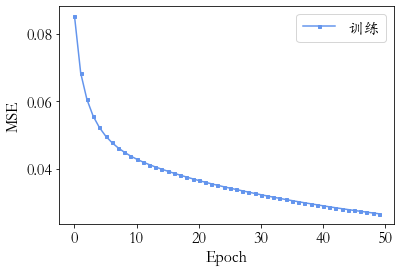

In [5]:
def train(epochs) :
    losses = []
    train_dataset = load_data()
    w1, b1, w2, b2, w3, b3 = init_paramaters()
    for epoch in range(epochs) :
        loss = train_epoch(epoch, train_dataset, w1, b1, w2, b2, w3, b3, lr = 0.01)
        losses.append(loss)
    x = [i for i in range(0, epochs)]
    # 绘制曲线
    plt.plot(x, losses, color = 'cornflowerblue', marker = 's', label = '训练', markersize='3')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.savefig('MNIST数据集的前向传播训练误差曲线.png')
    plt.show()
    plt.close()

if __name__ == '__main__' :
	# x 轴 0 ~ 50
    train(epochs = 50)